## load pkgs

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import os

In [2]:
sc.set_figure_params(dpi=120, dpi_save=300, vector_friendly=False, figsize=(4,4))
sc.settings.verbosity = 1
sc.logging.print_header()

%matplotlib inline 

scanpy==1.9.6 anndata==0.10.3 umap==0.5.5 numpy==1.26.2 scipy==1.10.1 pandas==2.1.4 scikit-learn==1.3.2 statsmodels==0.14.0 igraph==0.10.4 pynndescent==0.5.11


## plot setting

In [ ]:
%run ./py_script/marker.py

In [ ]:
%run ./py_script/colorconfig.py

## workpath

In [ ]:
# tumor
workdir = '/home/zhepan/Project/MultiOmics/data/snRNA/Object/'
sample_list = ['P1013S2','P1015S2','P1018S1']
resdir = '/home/zhepan/Project/MultiOmics/data/snRNA/Object/summary/test'

In [3]:
# skin
workdir = '/home/zhepan/Project/MultiOmics/data/skin/'
sample_list = ['SKIN-A1002','SKIN-B1002','SKIN-A1007','SKIN-B1007','SKIN-A1009','SKIN-B1009']
resdir = '/home/zhepan/Project/MultiOmics/data/skin/res'

In [4]:
filtertype = 'cellranger'

## process

In [ ]:
adatas = [sc.read_h5ad(workdir+'/'+sample+'/raw/'+filtertype+'_doublet.h5ad') for sample in sample_list]

In [ ]:
for index, adata in enumerate(adatas):
    adatas[index].obs_names = [obs_name[0:16] for obs_name in adatas[index].obs_names]

In [ ]:
adata = ad.concat([adatas[index] for index,adata in enumerate(adatas)], uns_merge='same', keys = sample_list, join='outer')
adata.obs_names = adata.obs_names + '-' + adata.obs['SampleID'].tolist()
adata

In [ ]:
adata.obs['SampleID'].value_counts()

In [ ]:
adata.write_h5ad(resdir+'/'+filtertype+'_raw.h5ad')

In [5]:
adata = sc.read_h5ad(resdir+'/'+filtertype+'_raw.h5ad')

In [6]:
mt_gene = adata.var_names[adata.var_names.str.startswith('MT-')]
hb_gene = adata.var_names[adata.var_names.str.contains('^HB[^P]')]
rp_gene = adata.var_names[adata.var_names.str.startswith(('RPS','RPL'))]

In [7]:
remove_gene = np.concatenate([mt_gene], axis = None)
remove_gene

array(['MT-ATP6', 'MT-ATP8', 'MT-CO1', 'MT-CO2', 'MT-CO3', 'MT-CYB',
       'MT-ND1', 'MT-ND2', 'MT-ND3', 'MT-ND4', 'MT-ND4L', 'MT-ND5',
       'MT-ND6'], dtype=object)

In [8]:
# optional
adata = adata[:,adata.var_names.isin(remove_gene) == False]

In [ ]:
%%capture --no-display
sc.pl.highest_expr_genes(adata, n_top=20,save='highest_expr_genes.pdf')

In [9]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


In [ ]:
%%capture --no-display
sc.pl.violin(adata, [
    'nFeature_RNA',
    'nCount_RNA', 
    'percent_mt',
    #'percent_hb'
    ],groupby='SampleID',
    jitter=0.4, multi_panel=True,stripplot=False)

In [ ]:
sc.pl.scatter(adata, x='nCount_RNA', y='nFeature_RNA')

In [ ]:
adata.obs.groupby('SampleID')['percent_mt'].describe()

In [10]:
adata = adata[adata.obs.nFeature_RNA < 5000, :]
adata = adata[adata.obs.nCount_RNA < 20000, :]
adata = adata[adata.obs.nCount_RNA > 500,:]
#adata = adata[adata.obs.percent_mt < 10, :]
#adata = adata[adata.obs.percent_hb < 0.2, :]

In [11]:
adata = adata[adata.obs['scDblFinder.class'] == 'singlet', :]

In [12]:
adata.obs.SampleID.value_counts()

SampleID
SKIN-B1007    11826
SKIN-A1009    11697
SKIN-B1002    11585
SKIN-B1009    11469
SKIN-A1007     6648
SKIN-A1002     6596
Name: count, dtype: int64

In [ ]:
%%capture --no-display
sc.pl.violin(adata, ['nFeature_RNA', 'nCount_RNA', 'percent_mt'],groupby='SampleID',
             jitter=0.4, multi_panel=True,stripplot=False)

/tmp/ipykernel_1847567/709545459.py:4: ImplicitModificationWarning: Setting element `.layers['count']` of view, initializing view as actual.
  adata_sample.layers['count'] = adata_sample.X.copy()


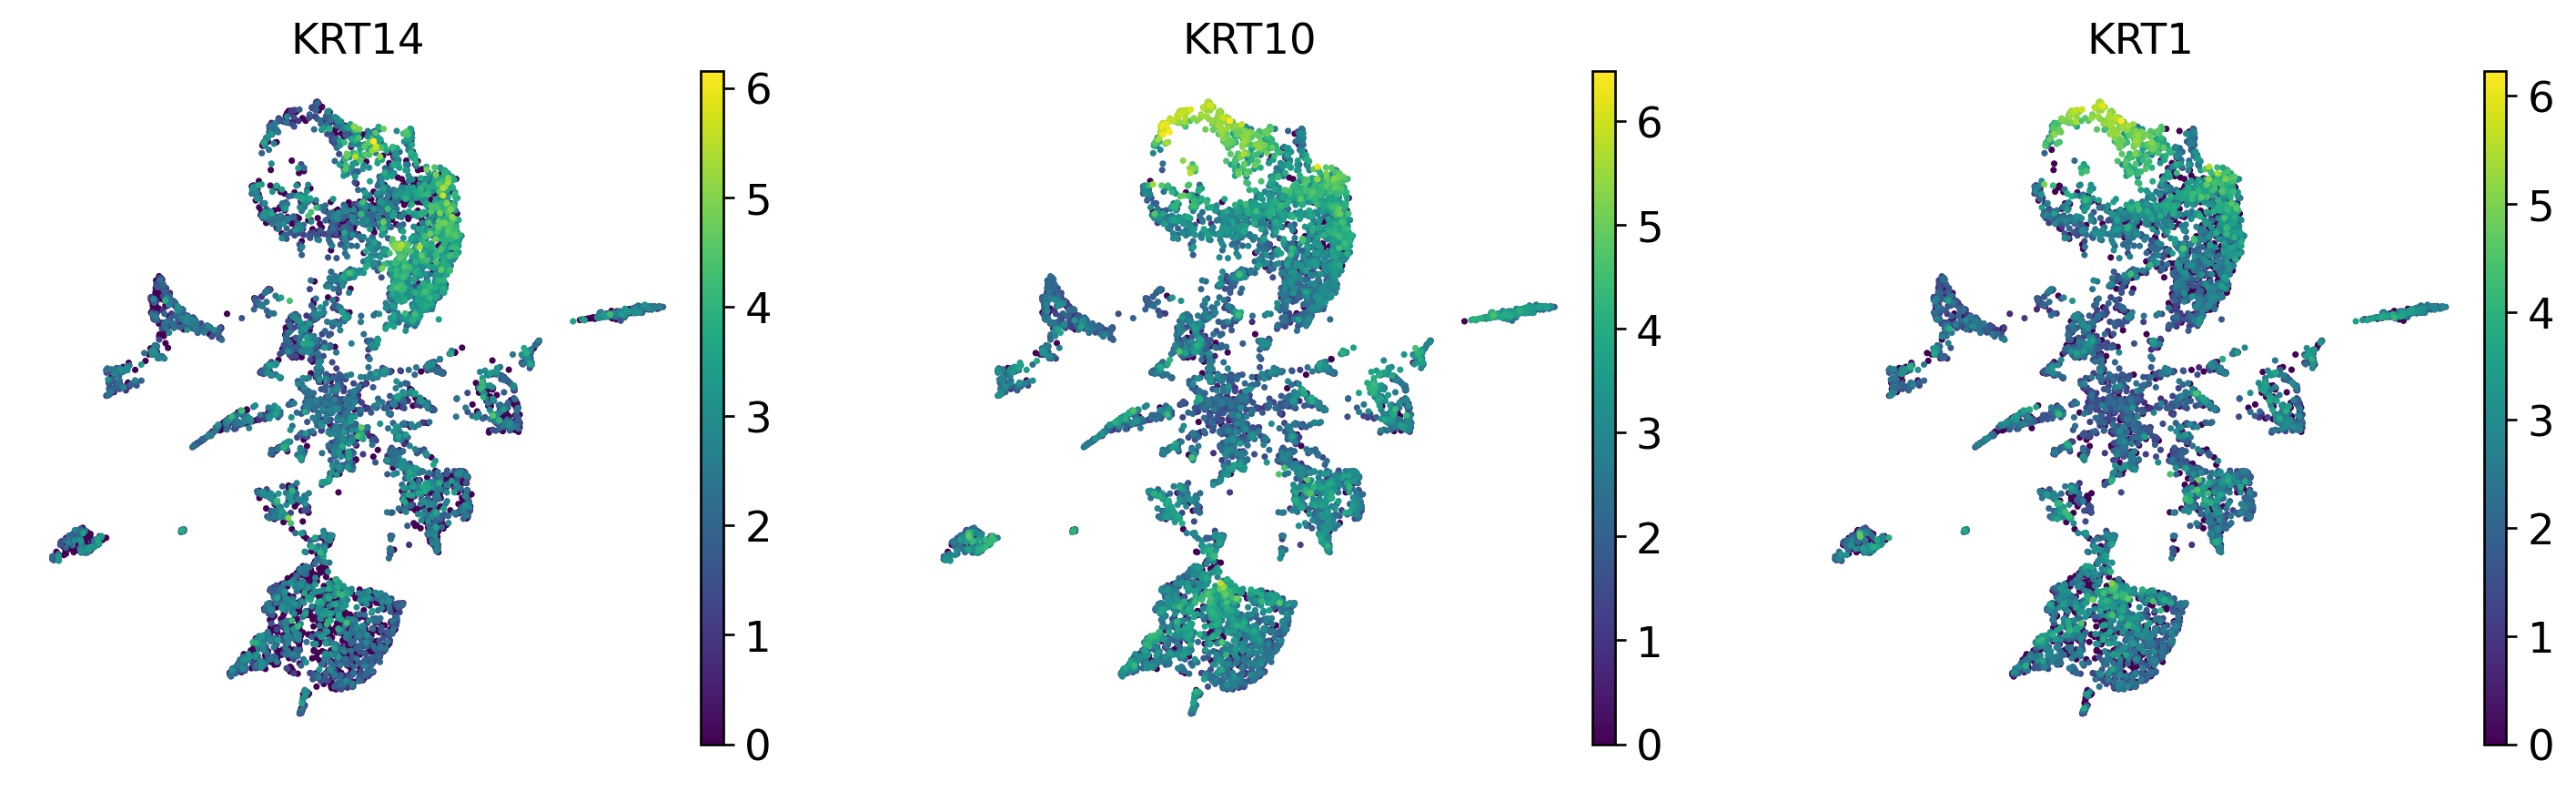

/tmp/ipykernel_1847567/709545459.py:4: ImplicitModificationWarning: Setting element `.layers['count']` of view, initializing view as actual.
  adata_sample.layers['count'] = adata_sample.X.copy()


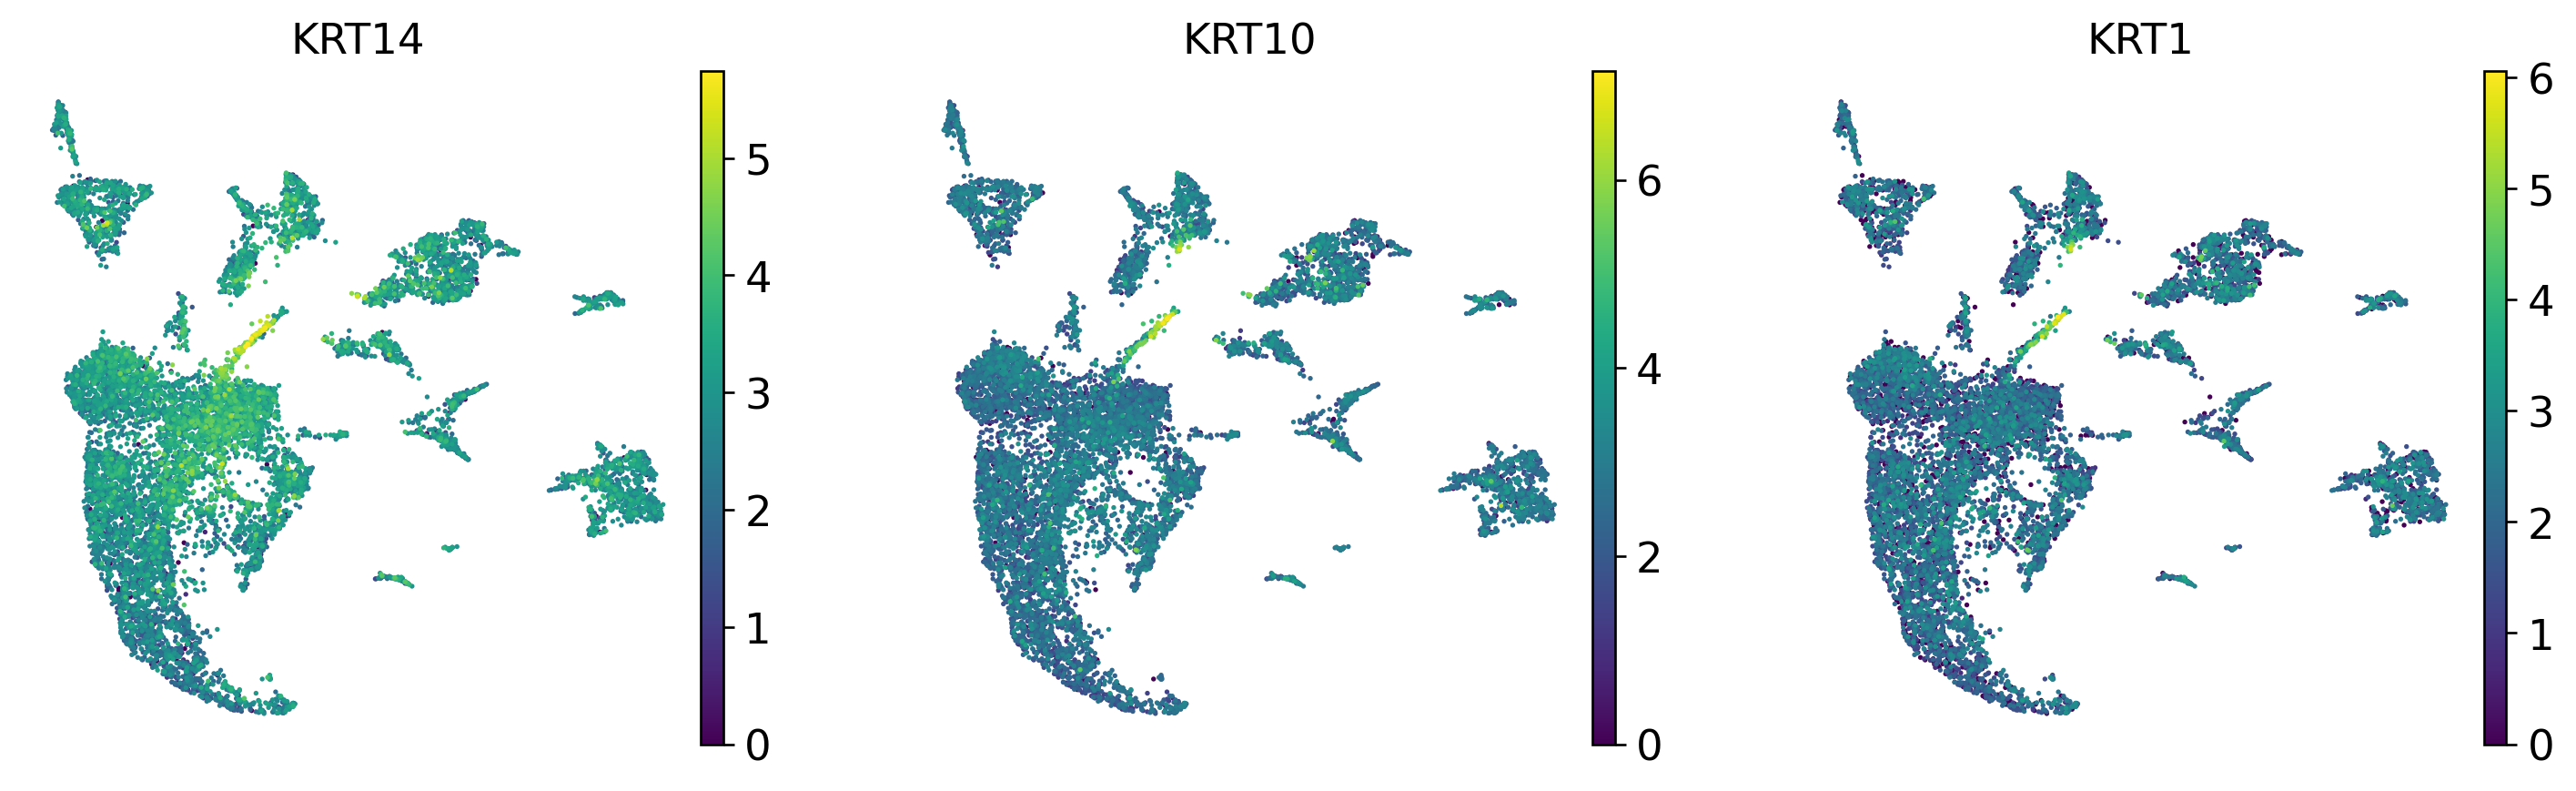

/tmp/ipykernel_1847567/709545459.py:4: ImplicitModificationWarning: Setting element `.layers['count']` of view, initializing view as actual.
  adata_sample.layers['count'] = adata_sample.X.copy()


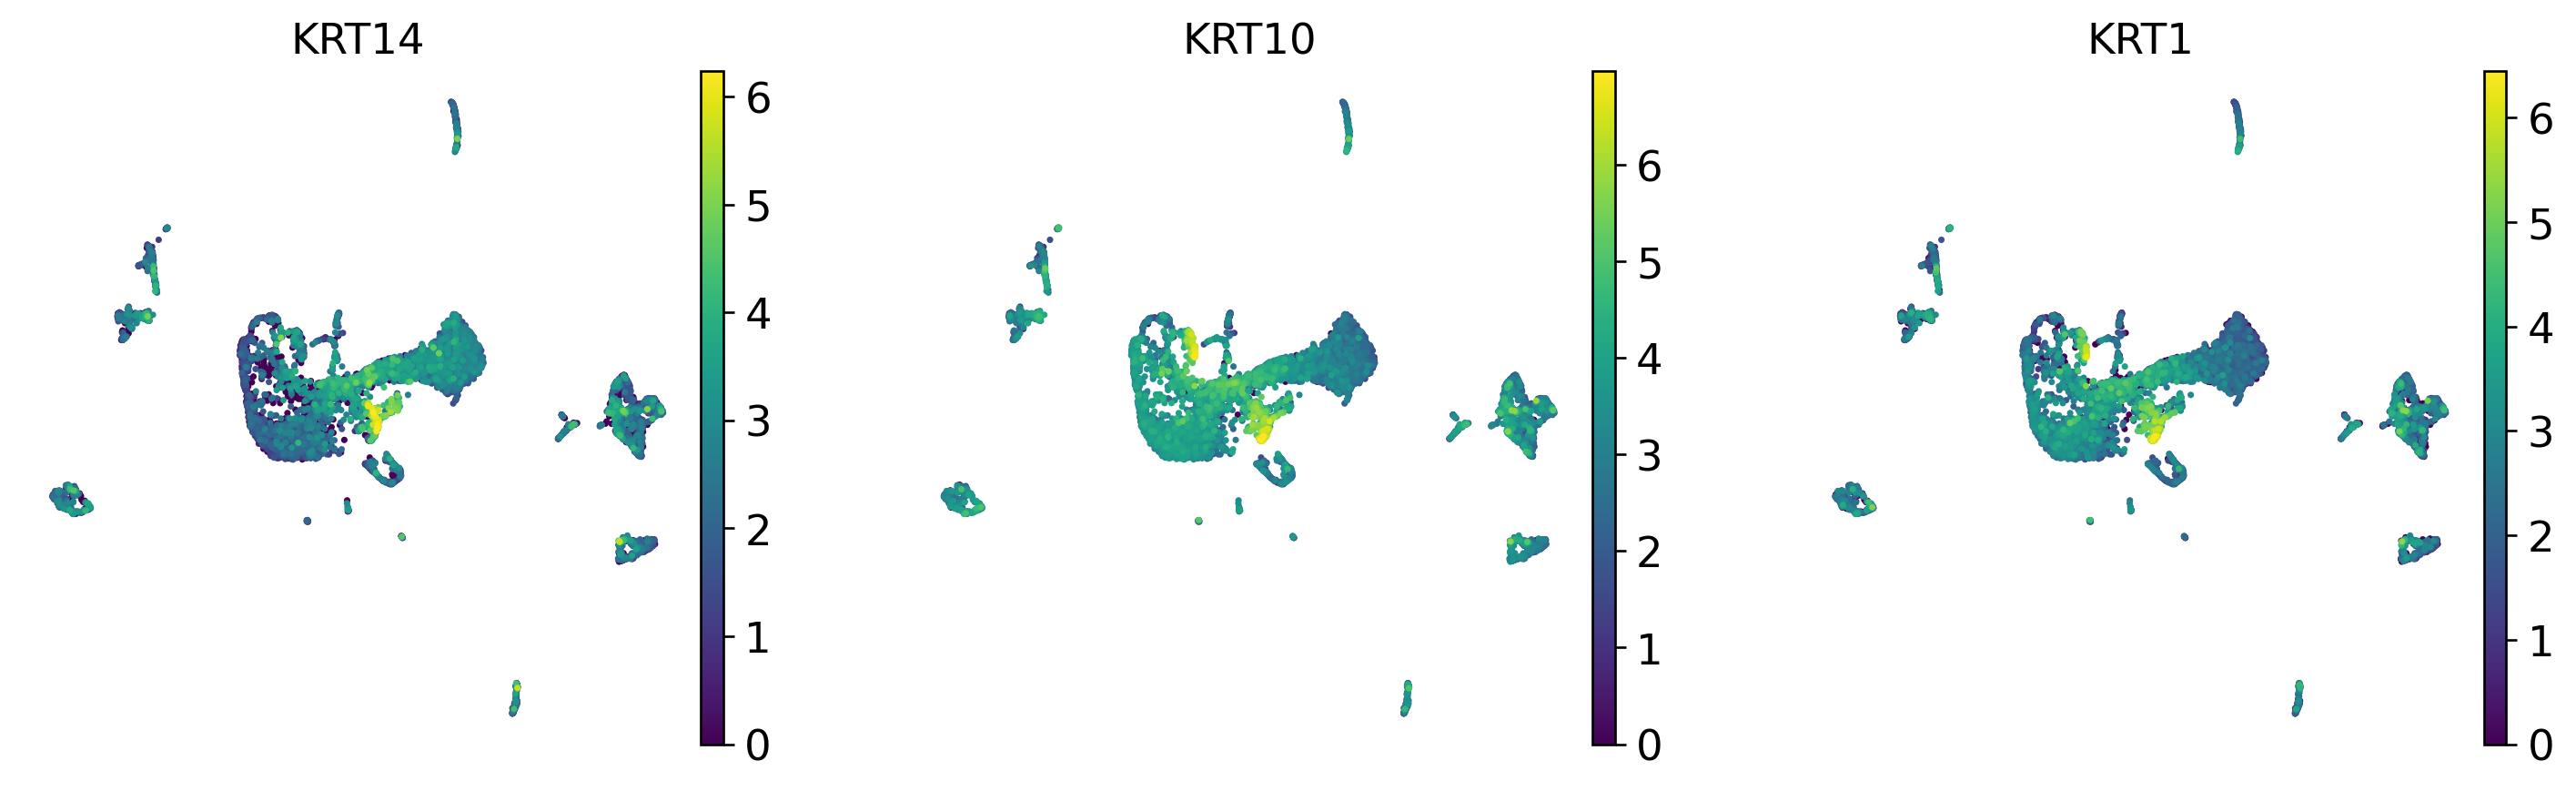

/tmp/ipykernel_1847567/709545459.py:4: ImplicitModificationWarning: Setting element `.layers['count']` of view, initializing view as actual.
  adata_sample.layers['count'] = adata_sample.X.copy()


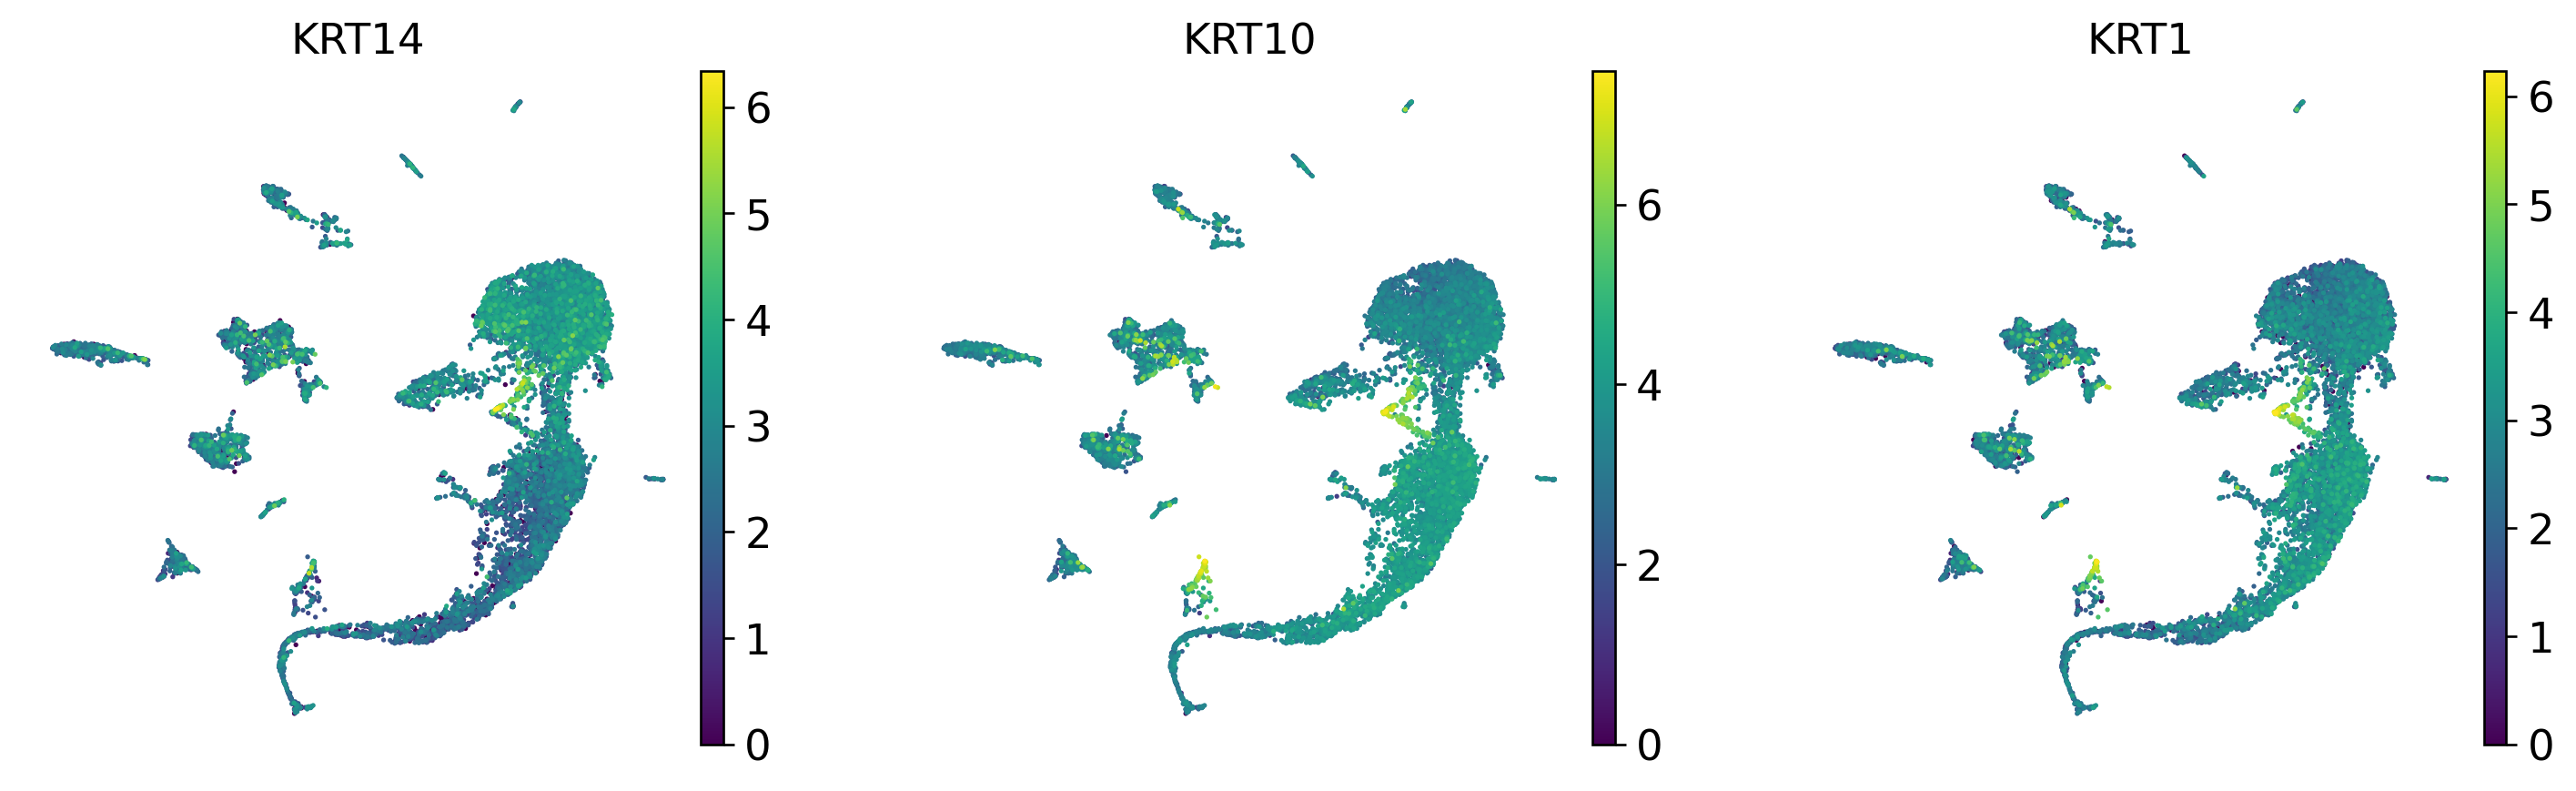

/tmp/ipykernel_1847567/709545459.py:4: ImplicitModificationWarning: Setting element `.layers['count']` of view, initializing view as actual.
  adata_sample.layers['count'] = adata_sample.X.copy()


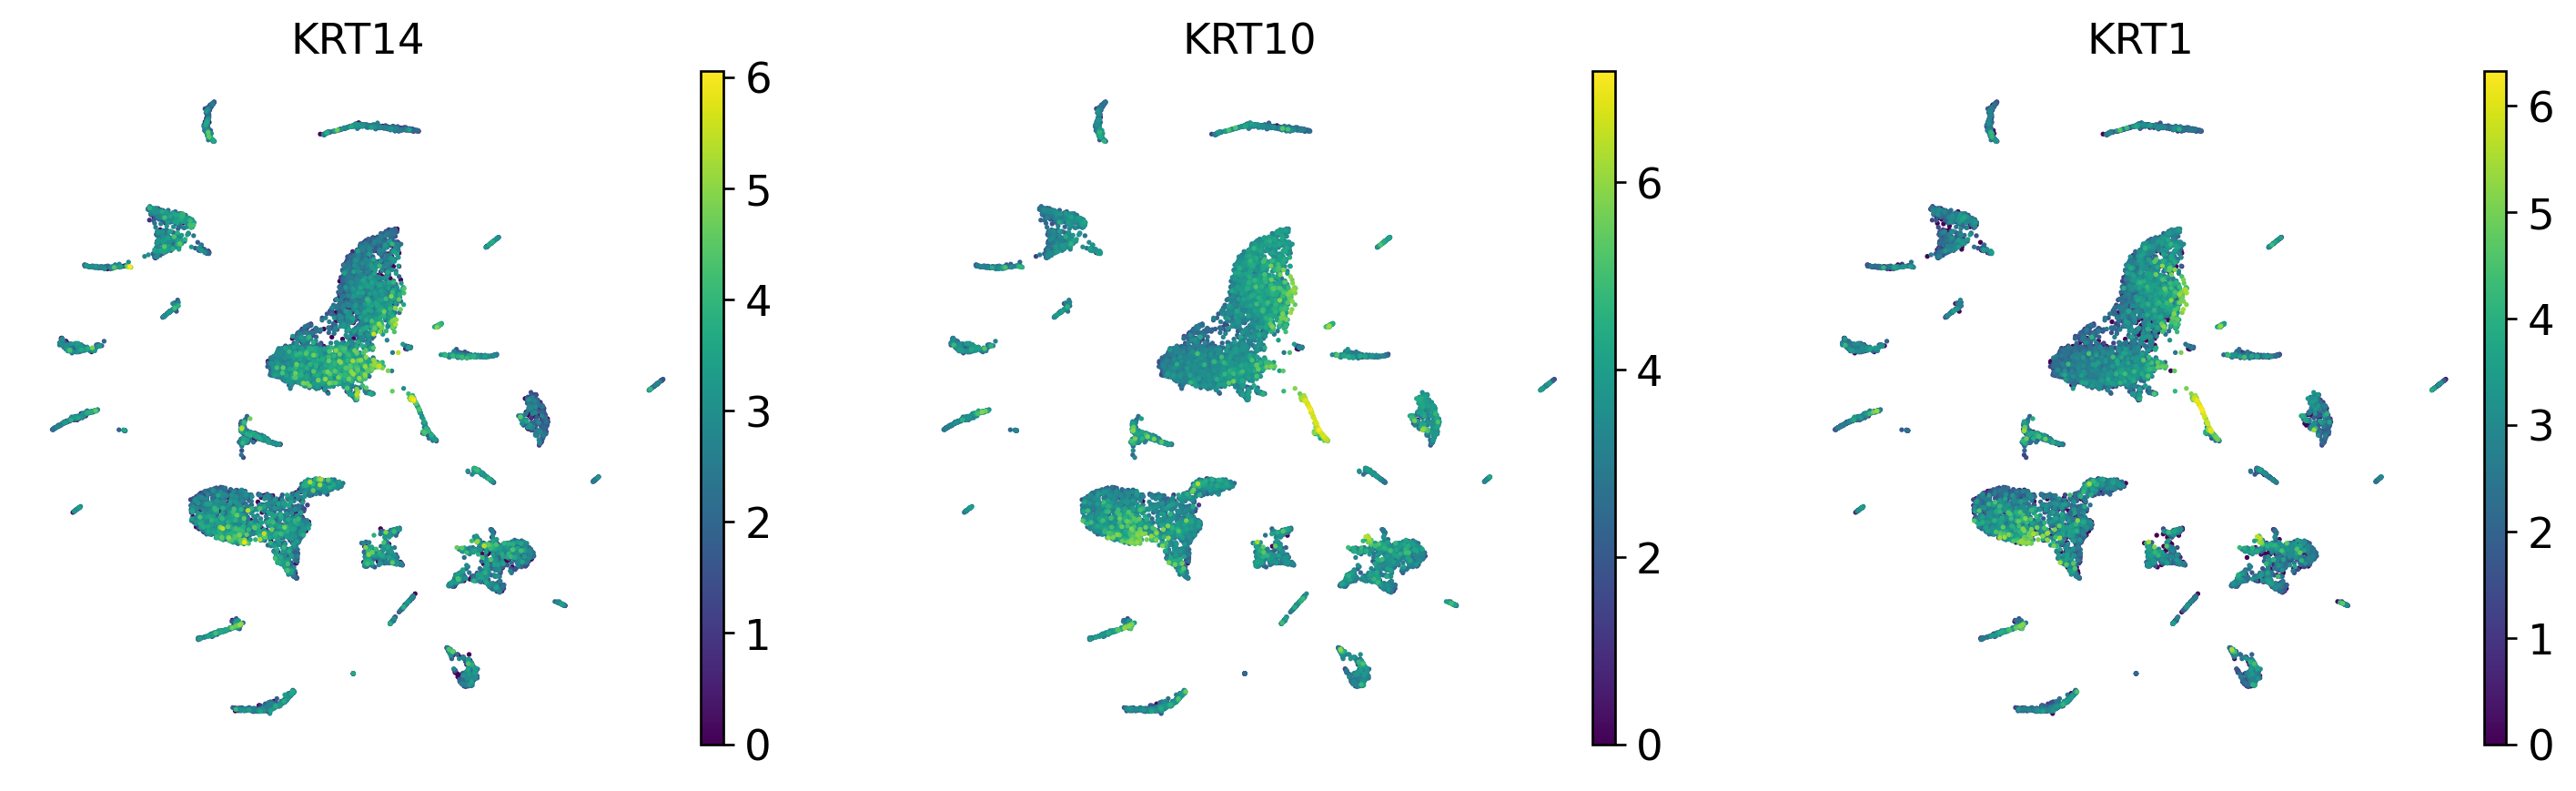

/tmp/ipykernel_1847567/709545459.py:4: ImplicitModificationWarning: Setting element `.layers['count']` of view, initializing view as actual.
  adata_sample.layers['count'] = adata_sample.X.copy()


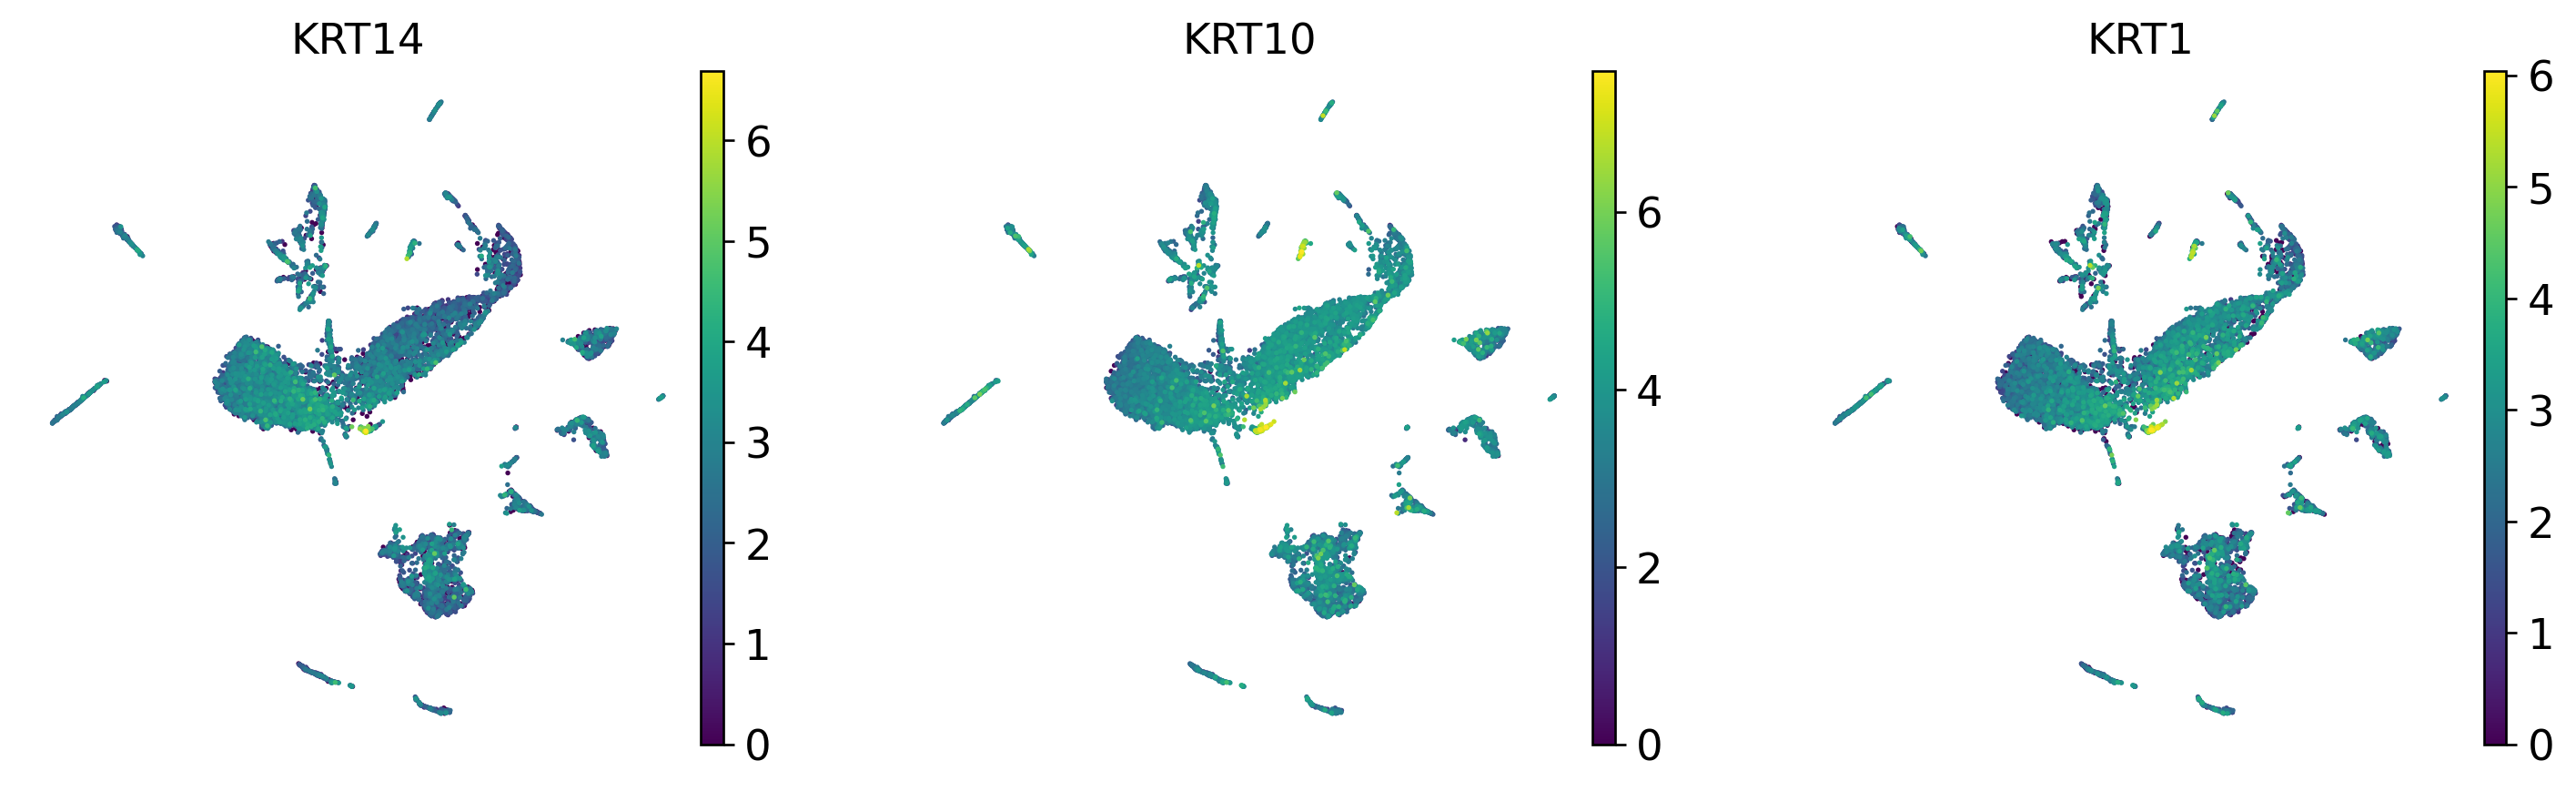

In [13]:
# ambient RNA check each data with KRT-genelist
for sample in sample_list:
    adata_sample = adata[adata.obs['SampleID'] == sample, :]
    adata_sample.layers['count'] = adata_sample.X.copy()
    sc.pp.normalize_total(adata_sample, target_sum=1e4)
    sc.pp.log1p(adata_sample)
    adata_sample.raw = adata_sample
    sc.pp.highly_variable_genes(
    adata_sample,layer = 'count',
    flavor="seurat_v3",
    n_top_genes=4000,
    batch_key="SampleID",
    subset=True)
    sc.pp.scale(adata_sample, max_value=10)
    sc.tl.pca(adata_sample, svd_solver='arpack')
    sc.pp.neighbors(adata_sample, n_neighbors=15, n_pcs=40)
    sc.tl.umap(adata_sample,min_dist=0.2)
    sc.pl.umap(adata_sample,color = ['KRT14','KRT10','KRT1'], ncols = 3, frameon= False, show=False, save = sample+'_KRT.pdf')

In [ ]:
adata.write_h5ad(resdir+'/'+filtertype+'_qc.h5ad')

In [ ]:
adata = sc.read_h5ad(resdir+'/'+filtertype+'_qc.h5ad')

In [ ]:
adata.layers['count'] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

In [ ]:
sc.pp.highly_variable_genes(
    adata,layer = 'count',
    flavor="seurat_v3",
    n_top_genes=4000,
    batch_key="SampleID",
    subset=True,
)

In [ ]:
#sc.pp.regress_out(adata, ['S_score', 'G2M_score'])
sc.pp.scale(adata, max_value=10)

In [ ]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

In [ ]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata,min_dist=0.2)

In [ ]:
sc.pl.umap(adata,color = ['SampleID','SampleType'], ncols = 2)

In [ ]:
sc.pl.umap(adata,color = ['KRT14','KRT1','KRT10'], frameon= False, ncols = 3, save = 'KRT.pdf')

In [ ]:
import scanpy.external as sce

In [ ]:
sce.pp.harmony_integrate(adata, ['SampleID','SampleType'],max_iter_harmony=20)

In [ ]:
sc.pp.neighbors(adata, use_rep='X_pca_harmony',n_neighbors=15, n_pcs=40)

In [ ]:
sc.tl.umap(adata,min_dist=0.2)
sc.pl.umap(adata, color=["SampleID",'SampleType'], frameon=False, ncols=2)

In [ ]:
sc.pl.umap(adata,color = ['KRT14','KRT1','KRT10'],frameon= False, ncols = 3, save = 'harmony_KRT.pdf')

In [ ]:
for i in [1.0,1.4,1.7,2.0]:
    sc.tl.leiden(adata, resolution = i, key_added = ('harmony_leiden_'+str(i)))

In [ ]:
sc.pl.umap(adata, color=[ "harmony_leiden_1.0","harmony_leiden_1.4"], frameon=False, ncols=4)

In [ ]:
%%capture --no-display
sc.pl.violin(adata, ['percent_mt'],groupby='harmony_leiden_1.0',
             jitter=0.4, multi_panel=True,stripplot=False)

In [ ]:
adata.write_h5ad(resdir+'/'+filtertype+'_harmony.h5ad')

In [ ]:
pd.crosstab(adata.obs['harmony_leiden_1.0'],adata.obs['SampleID'])

In [ ]:
remove_group

In [ ]:
cluster_select = 'harmony_leiden_1.0'
remove_group = list(map(str, range(23, 26)))+['17','20','27','28','29','30']
sc.pl.umap(adata, color=[cluster_select], groups=remove_group, frameon=False)

In [ ]:
adata_qc = sc.read_h5ad(resdir+'/'+filtertype+'_qc.h5ad')

In [ ]:
adata_qc.obs = adata_qc.obs.join(adata.obs['harmony_leiden_1.0'], how='left')

In [ ]:
sc.pp.normalize_total(adata_qc, target_sum = 1e4)
sc.pp.log1p(adata_qc)

In [ ]:
%%capture --no-display
sc.tl.rank_genes_groups(adata_qc, 'harmony_leiden_1.0', method='wilcoxon')

In [ ]:
marker_enrich = pd.DataFrame(adata_qc.uns['rank_genes_groups']['names'])

In [ ]:
import gseapy as gp
import decoupler as dc

In [ ]:
enr = gp.enrichr(marker_enrich['22'].head(20), gene_sets=['Azimuth_2023'], organism='human', outdir=None)
enr.results.head(5)

In [ ]:
index_keep = adata.obs[adata.obs[cluster_select].isin(remove_group)==False].index

In [ ]:
adata_qc = sc.read_h5ad(resdir+'/'+filtertype+'_qc.h5ad')

In [ ]:
adata_keep = adata_qc[adata_qc.obs.index.isin(index_keep),:]
adata_keep

In [ ]:
adata_keep.layers['count'] = adata_keep.X.copy()
sc.pp.normalize_total(adata_keep, target_sum=1e4)
sc.pp.log1p(adata_keep)
adata_keep.raw = adata_keep
sc.pp.highly_variable_genes(
    adata_keep,layer = 'count',
    flavor="seurat_v3",
    n_top_genes=3000,
    batch_key="SampleID",
    subset=True,
)

In [ ]:
sc.pp.scale(adata_keep)
sc.tl.pca(adata_keep, svd_solver='arpack')

In [ ]:
sce.pp.harmony_integrate(adata_keep, ['SampleID','SampleType'],max_iter_harmony=20)
sc.pp.neighbors(adata_keep, use_rep='X_pca_harmony',n_neighbors=15, n_pcs=40)

In [ ]:
sc.tl.umap(adata_keep,min_dist=0.2)

In [ ]:
for i in [0.8,1.0,1.2,1.4]:
    sc.tl.leiden(adata_keep, resolution = i, key_added = ('keep_leiden_'+str(i)))

In [ ]:
pd.crosstab(adata_keep.obs['keep_leiden_1.0'],adata.obs['harmony_leiden_1.0'])

In [ ]:
sc.pl.umap(adata_keep, color=['SampleID'], frameon=False, ncols=2)

In [ ]:
sc.pl.umap(adata_keep, color=['keep_leiden_0.8','keep_leiden_1.0','keep_leiden_1.2','keep_leiden_1.4'], frameon=False, ncols=2)

In [ ]:
pd.crosstab(adata_keep.obs['keep_leiden_1.0'],adata_keep.obs['SampleID'])

In [ ]:
adata_deg = sc.read_h5ad(resdir+'/'+filtertype+'_qc.h5ad')

In [ ]:
adata_deg = adata_deg[adata_deg.obs.index.isin(index_keep),:]

In [ ]:
adata_deg.obs = adata_deg.obs.join(adata_keep.obs['keep_leiden_1.0'], how='left')

In [ ]:
sc.pp.normalize_total(adata_deg, target_sum = 1e4)
sc.pp.log1p(adata_deg)

In [ ]:
%%capture --no-display
sc.tl.rank_genes_groups(adata_deg, 'keep_leiden_1.0', method='wilcoxon')
sc.tl.filter_rank_genes_groups(adata_deg, min_fold_change=1.5,min_in_group_fraction=0.8,max_out_group_fraction=0.2)

In [ ]:
adata_deg

In [ ]:
sc.pl.rank_genes_groups_dotplot(adata_deg, key='rank_genes_groups',dendrogram=False,n_genes =5)

In [ ]:
df_markers = sc.get.rank_genes_groups_df(adata_deg, group=adata_deg.obs['keep_leiden_1.0'].unique(), key='rank_genes_groups_filtered')
df_markers = df_markers.loc[~ df_markers.names.isna()]
df_markers.to_csv(resdir + 'markers.csv')

In [ ]:
marker_enrich = pd.DataFrame(adata_deg.uns['rank_genes_groups']['names'])

In [ ]:
enr = gp.enrichr(marker_enrich['13'].head(50), gene_sets=['Azimuth_2023'], organism='human', outdir=None)
enr.results.head(5)

In [ ]:
sc.pl.umap(adata_keep, color=['keep_leiden_1.0'], frameon=False, ncols=2)

In [ ]:
sc.pl.umap(adata_keep, color=['KRT14','KRT10','KRT1'],use_raw=True)

In [ ]:
import celltypist

In [ ]:
pred_GTEx_major = celltypist.annotate(adata_deg, model = '/home/zhepan/Reference/celltypist/skin_major_from_GTEx.pkl', majority_voting = True)
pred_GTEx_minor = celltypist.annotate(adata_deg, model = '/home/zhepan/Reference/celltypist/skin_minor_from_GTEx.pkl', majority_voting = True)
pred_TS_compart = celltypist.annotate(adata_deg, model = '/home/zhepan/Reference/celltypist/skin_compartment_from_TS.pkl', majority_voting = True)
pred_TS_subset = celltypist.annotate(adata_deg, model = '/home/zhepan/Reference/celltypist/skin_subset_from_TS.pkl', majority_voting = True)
pred_deve_minor = celltypist.annotate(adata_deg, model = '/home/zhepan/Reference/celltypist/skin_minor_from_Develop.pkl', majority_voting = True)
pred_deve_subset = celltypist.annotate(adata_deg, model = '/home/zhepan/Reference/celltypist/skin_subset_from_Develop.pkl', majority_voting = True)

In [ ]:
pred_GTEx_major.predicted_labels['predicted_labels'].value_counts()

In [ ]:
adata_keep.obs = adata_keep.obs.join(pred_GTEx_major.predicted_labels['predicted_labels']).rename(columns={'predicted_labels':'GTEx_major'})
adata_keep.obs = adata_keep.obs.join(pred_GTEx_minor.predicted_labels['predicted_labels']).rename(columns={'predicted_labels':'GTEx_minor'})
adata_keep.obs = adata_keep.obs.join(pred_TS_compart.predicted_labels['predicted_labels']).rename(columns={'predicted_labels':'TS_compart'})
adata_keep.obs = adata_keep.obs.join(pred_TS_subset.predicted_labels['predicted_labels']).rename(columns={'predicted_labels':'TS_subset'})
adata_keep.obs = adata_keep.obs.join(pred_deve_minor.predicted_labels['predicted_labels']).rename(columns={'predicted_labels':'deve_minor'})
adata_keep.obs = adata_keep.obs.join(pred_deve_subset.predicted_labels['predicted_labels']).rename(columns={'predicted_labels':'deve_subset'})

In [ ]:
pd.crosstab(adata_keep.obs['SampleID'], adata_keep.obs['GTEx_major'])

In [ ]:
sc.pl.umap(adata_keep, color = ['GTEx_major','TS_subset','deve_minor'], ncols=1, legend_fontsize='xx-small')

In [ ]:
pd.crosstab(adata_keep.obs['keep_leiden_1.0'], adata_keep.obs['deve_minor'])

In [ ]:
sc.pl.umap(adata_keep, color = ['keep_leiden_1.0'], groups=['12','21'], ncols=1, legend_fontsize='xx-small')

In [ ]:
cl_major={
    "0": "Epithelial",
    "1": "Epithelial",
    "2": "Epithelial",
    "3": "Epithelial",
    "4": "Fibroblast",
    "5": "Endothelial",
    "6": "Epithelial",
    "7": "Melanocyte",
    "8": "Fibroblast",
    "9": "Myeloid",
    "10": "Epithelial",
    "11": "Fibroblast",
    "12": "Epithelial",
    "13": "Epithelial",
    "14": "T cell",
    "15": "Muscle",
    "16": "Endothelial",
    "17": "Epithelial",
    "18": "Myeloid",
    "19": "Epithelial",
    "20": "Muscle",
    "21": "Epithelial",
    "22": "Mast cell",
    "23": "Epithelial",
    "24": "Schwann cell",
}

In [ ]:
adata_keep.obs["cl_major"] = adata_keep.obs['keep_leiden_1.0'].map(cl_major)

In [ ]:
sc.pl.umap(adata_keep,color = ['cl_major'], frameon=False)

In [ ]:
adata_deg.obs['cl_major'] = adata_keep.obs['cl_major']

In [ ]:
%%capture --no-display
sc.tl.rank_genes_groups(adata_deg, 'cl_major', method='wilcoxon')
sc.tl.filter_rank_genes_groups(adata_deg, min_fold_change=1.5,min_in_group_fraction=0.8,max_out_group_fraction=0.2)

In [ ]:
sc.tl.filter_rank_genes_groups(adata_deg, min_fold_change=1.5)

In [ ]:
sc.pl.rank_genes_groups_dotplot(adata_deg, key='rank_genes_groups_filtered',dendrogram=False,n_genes =5)

In [ ]:
adata_keep_filter = adata_keep[adata_keep.obs['percent_mt']<5, :]

In [ ]:
pd.crosstab(adata_keep_filter.obs['SampleType'], adata_keep_filter.obs['keep_leiden_1.0'])

In [ ]:
adata_keep.obs.groupby('keep_leiden_1.0')['percent_mt'].describe()

In [ ]:
%%capture --no-display
sc.pl.violin(adata_keep, ['percent_mt'],groupby='keep_leiden_1.0',
             jitter=0.4, multi_panel=True, stripplot=False)

In [ ]:
adata_keep.obs.to_csv(resdir + '/celltype.csv')

In [ ]:
adata_keep.write_h5ad(resdir+'/'+filtertype+'_anno.h5ad')